In [1]:
# <-- Import libraries, custom functions, and load configuration & datasets <-- #

import yaml
import datetime as dt
import re
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import seaborn as sns

from statsmodels.multivariate.manova import MANOVA
from scipy import stats
from scipy.stats import pearsonr, boxcox, chi2_contingency, shapiro, probplot
from scipy.stats.contingency import association

sns.set(style="whitegrid")

# <-- Imports custom preprocessing functions from 'functions.py' <-- #

# from functions import ()

# <-- Loads YAML configuration to dynamically reference CSV output files. <-- #

config = None  # <-- Initialize config
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

df_proc_control = pd.read_csv(config['output_data']['file8'])
df_proc_test = pd.read_csv(config['output_data']['file9'])

In [2]:
df_proc_control[['t_start_step1','t_step1_step2','t_step2_step3','t_step3_conf','t_total','n_back_jumps']].describe()

,t_start_step1,t_step1_step2,t_step2_step3,t_step3_conf,t_total,n_back_jumps
count,16992.000000,13810.000000,12943.000000,10956.000000,10956.000000,22819.000000
mean,2.222788,0.925299,1.607815,2.339446,6.785173,0.260660
std,7.691675,1.552735,2.011254,2.676225,6.540227,0.640388
min,0.033333,0.000000,0.000000,0.000000,0.550000,0.000000
25%,0.233333,0.150000,0.616667,0.866667,3.133333,0.000000
50%,0.516667,0.400000,1.116667,1.450000,4.783333,0.000000
75%,1.333333,1.033333,1.900000,2.700000,7.933333,0.000000
max,699.283333,32.916667,42.666667,38.466667,132.450000,11.000000


In [3]:
df_proc_test[['t_start_step1','t_step1_step2','t_step2_step3','t_step3_conf','t_total','n_back_jumps']].describe()

,t_start_step1,t_step1_step2,t_step2_step3,t_step3_conf,t_total,n_back_jumps
count,22266.000000,18253.000000,16772.000000,14354.000000,14356.000000,25932.000000
mean,2.573227,0.873905,1.664498,2.463916,6.984293,0.479022
std,6.899954,2.412439,3.265456,6.066683,9.527472,0.970777
min,0.016667,0.000000,0.000000,0.000000,0.633333,0.000000
25%,0.150000,0.233333,0.700000,0.550000,2.616667,0.000000
50%,0.350000,0.433333,1.116667,1.033333,4.300000,0.000000
75%,2.250000,0.816667,1.783333,2.300000,7.750000,1.000000
max,299.383333,113.416667,114.183333,275.866667,300.250000,25.000000


In [4]:
plt.rcParams['figure.figsize'] = (7,4)

# 1) Choose the numeric columns to search for outliers
NUM_COLS = [
    't_total','t_start_step1','t_step1_step2','t_step2_step3','t_step3_conf','n_back_jumps'
]

**What the IQR limit is:**
- In this notebook we flag outliers with Tukey fences built from the inter-quartile range (IQR).

- Compute quartiles: Q1 (25th pct), Q3 (75th pct), and IQR = Q3 − Q1.

**Set bounds:**
- Lower = Q1 − k·IQR
- Upper = Q3 + k·IQR

- Any value outside these bounds is treated as an outlier.

**Why “3.0” or “1.5”?**
- Those numbers are the multiplier k:
- k = 1.5 → the classic Tukey fence for “mild” outliers. Good for catching clear anomalies while keeping most of the distribution.
- k = 3.0 → a stricter (wider) fence for “extreme” outliers only. Useful when metrics are naturally skewed (e.g., step times) and you want to avoid over-trimming legitimate long tails.

**Bottom line:**
- We use IQR because it’s robust to skew and heavy tails (unlike mean/σ rules). Pick 1.5 when we want conservative cleaning; pick 3.0 when we only want to remove the most extreme points.

In [5]:
# 2) Simple IQR Limit Calculation
def iqr_bounds(s: pd.Series, k: float = 3.0):
    x = s.dropna().values
    if len(x) == 0:
        return np.nan, np.nan
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

In [6]:
# 3) Quick Scan (prints counts and draws 2 graphs per variable)
def quick_outlier_scan(df: pd.DataFrame, cols=NUM_COLS, k: float = 3.0, title_prefix:str=""):
    for c in cols:
        lo, hi = iqr_bounds(df[c], k)
        n_out = int(((df[c] < lo) | (df[c] > hi)).sum())
        print(f"{title_prefix}{c}: outliers={n_out}, low={lo:.3f}, high={hi:.3f}")

        # Boxplot with IQR limits
        ax = sns.boxplot(x=df[c])
        if np.isfinite(lo): ax.axvline(lo, ls='--')
        if np.isfinite(hi): ax.axvline(hi, ls='--')
        ax.set_title(f"{title_prefix}{c} (box + IQR)"); 
        plt.show()

        # Simple histogram
        sns.histplot(df[c], kde=True)
        if np.isfinite(lo): plt.axvline(lo, ls='--')
        if np.isfinite(hi): plt.axvline(hi, ls='--')
        plt.title(f"{title_prefix}{c} (hist)"); 
        plt.show()

In [7]:
# 4) Remove outliers
def drop_outliers_iqr(df: pd.DataFrame, cols=NUM_COLS, k: float = 3.0, how:str='any'):
    """
    how='any' -> deletes a row if it's an outlier in at least one column
    how='all' -> deletes a row only if it's an outlier in all columns
    """
    d = df.copy()
    mask_out = pd.Series(False, index=d.index)      # Start with "no rows are outliers"
    for c in cols:
        lo, hi = iqr_bounds(d[c], k)
        col_out = (d[c] < lo) | (d[c] > hi)
        # Update global mask according to the chosen logic
        if how == 'any':
            mask_out = mask_out | col_out        # flag if outlier in ANY selected column
        else:  # 'all'
            mask_out = mask_out & col_out        # flag only if outlier in ALL columns
        #mask_out = (mask_out | col_out) if how=='any' else (mask_out & col_out)
    kept = d.loc[~mask_out].copy()
    removed = d.loc[mask_out].copy()
    return kept, removed

[CONTROL] t_total: outliers=338, low=-11.267, high=22.333


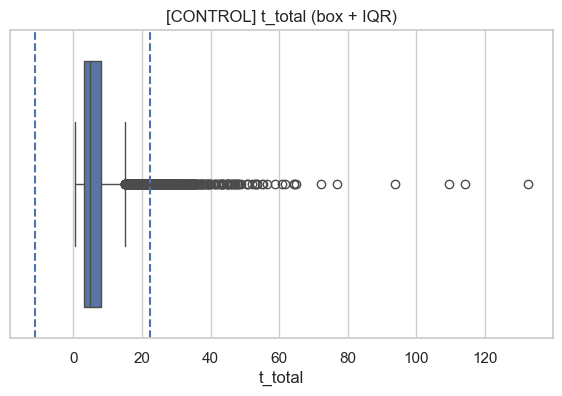

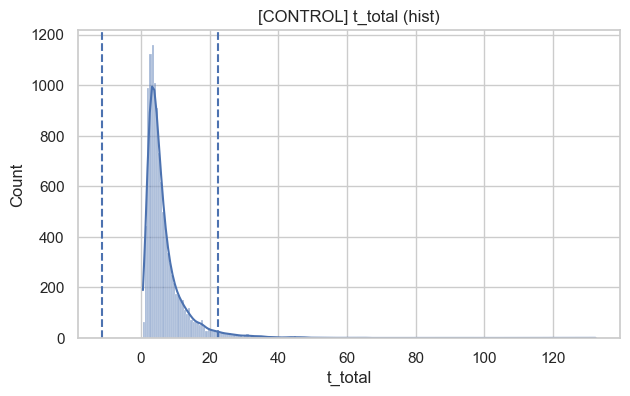

[CONTROL] t_start_step1: outliers=1975, low=-3.067, high=4.633


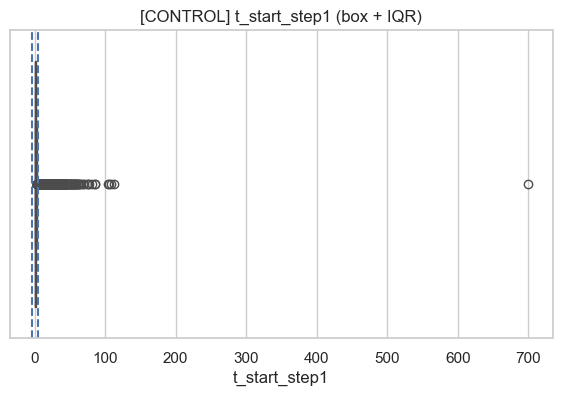

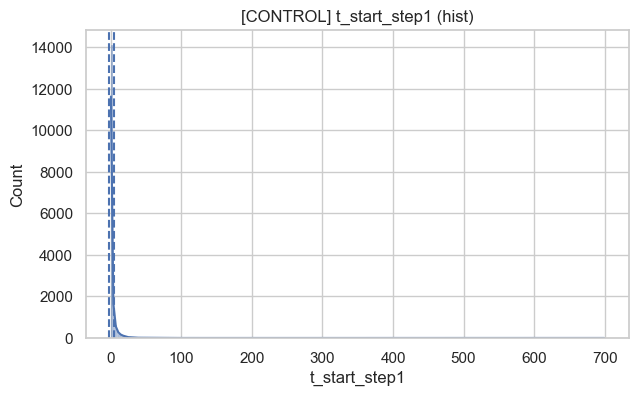

[CONTROL] t_step1_step2: outliers=611, low=-2.500, high=3.683


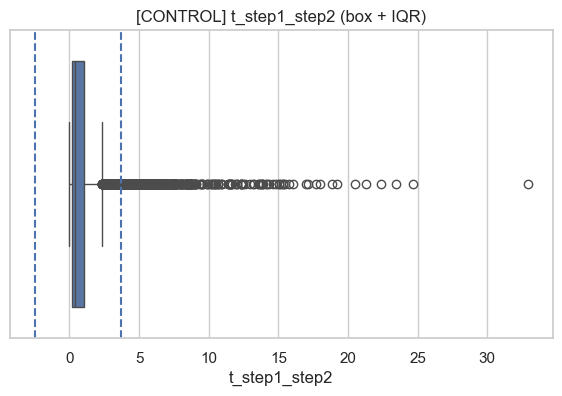

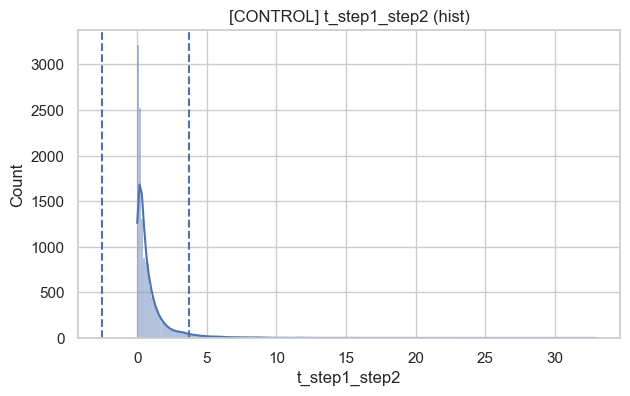

[CONTROL] t_step2_step3: outliers=392, low=-3.233, high=5.750


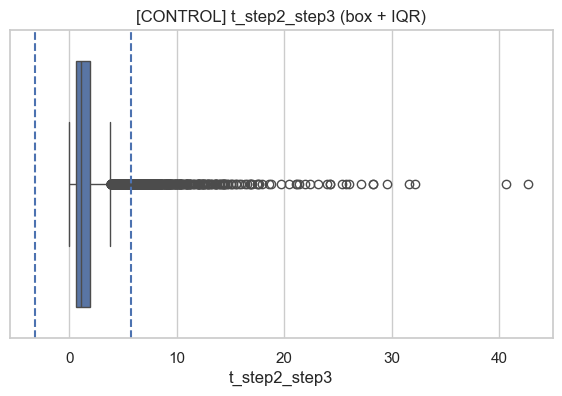

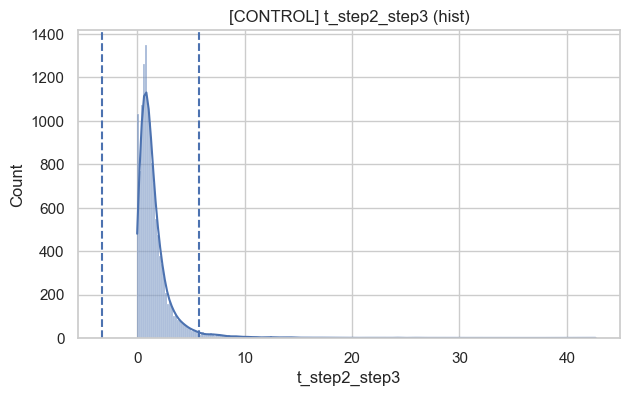

[CONTROL] t_step3_conf: outliers=447, low=-4.633, high=8.200


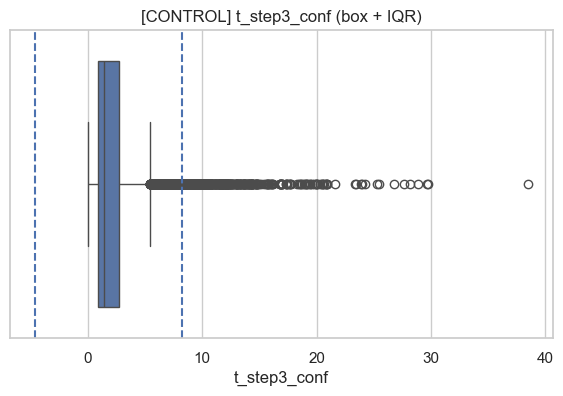

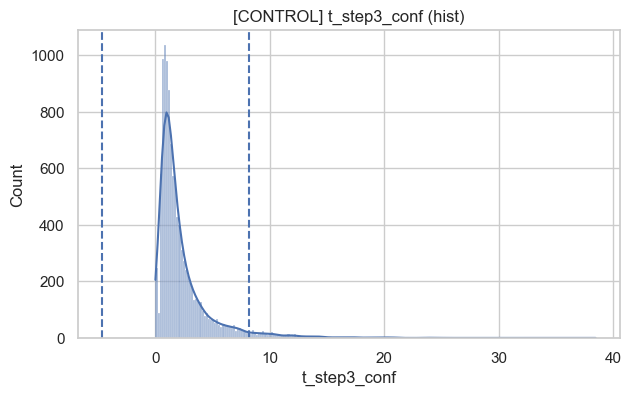

[CONTROL] n_back_jumps: outliers=4266, low=0.000, high=0.000


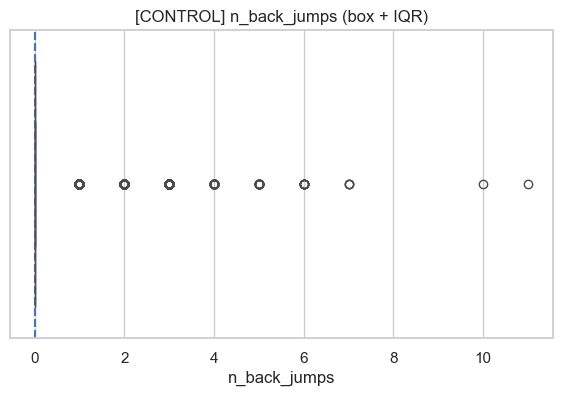

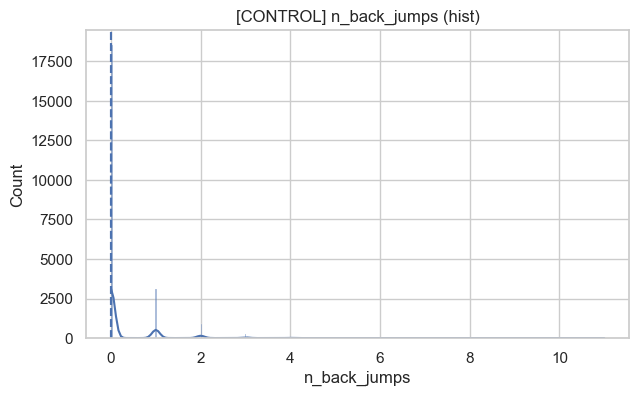

[TEST] t_total: outliers=564, low=-12.783, high=23.150


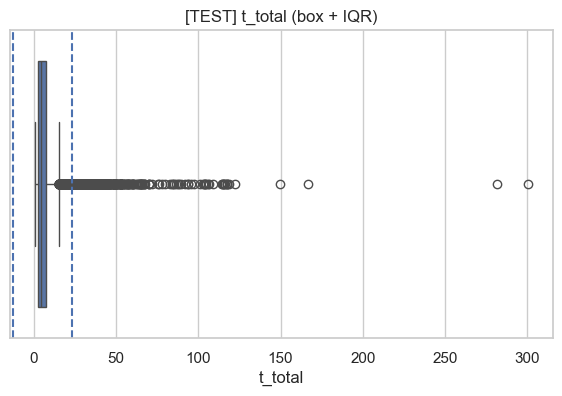

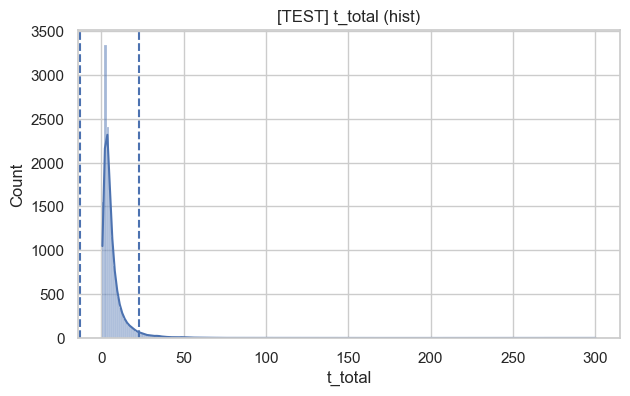

[TEST] t_start_step1: outliers=1637, low=-6.150, high=8.550


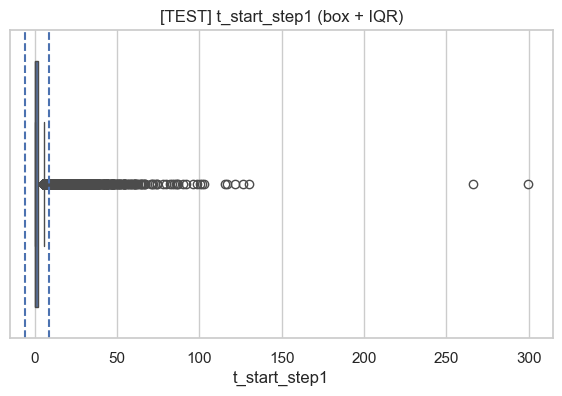

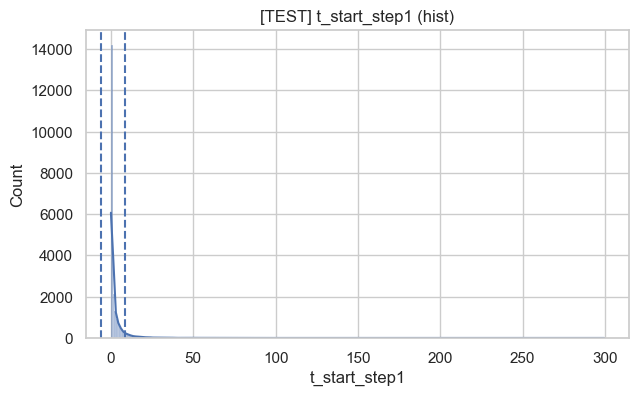

[TEST] t_step1_step2: outliers=966, low=-1.517, high=2.567


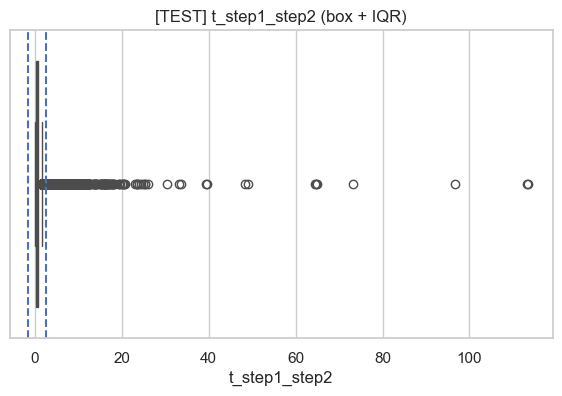

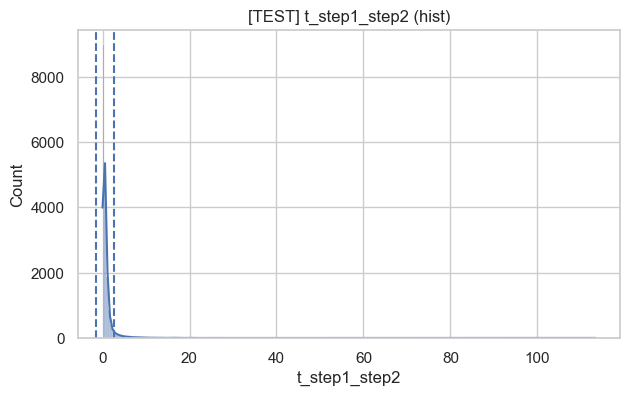

[TEST] t_step2_step3: outliers=600, low=-2.550, high=5.033


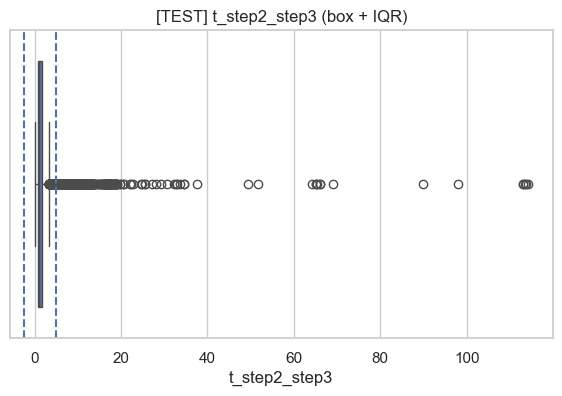

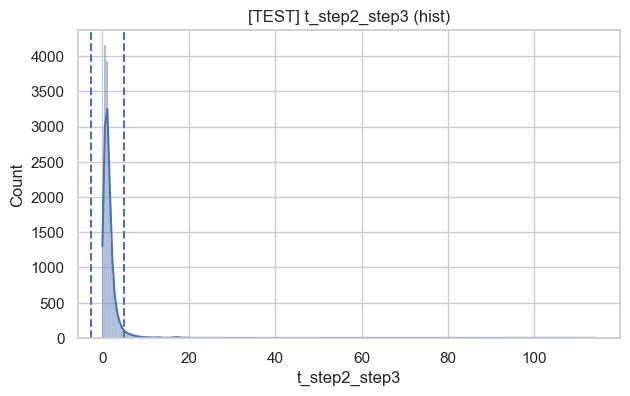

[TEST] t_step3_conf: outliers=866, low=-4.700, high=7.550


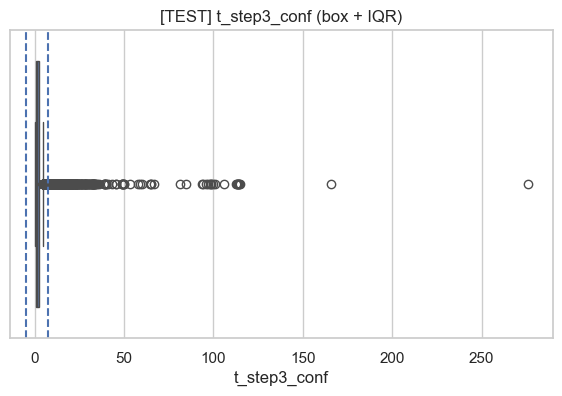

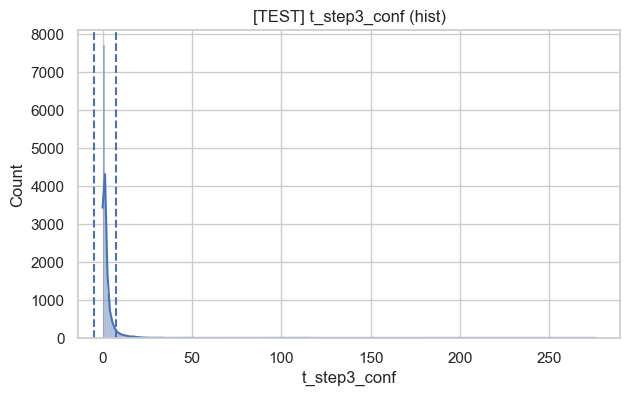

[TEST] n_back_jumps: outliers=204, low=-3.000, high=4.000


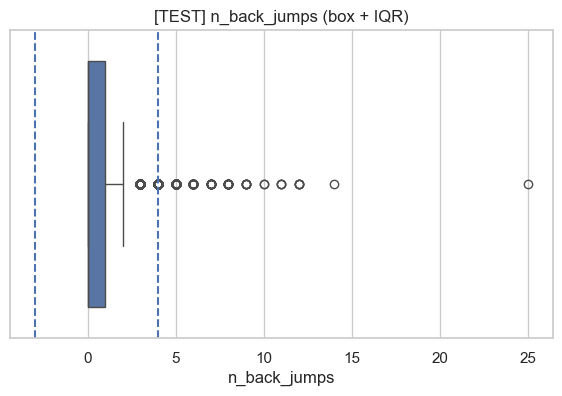

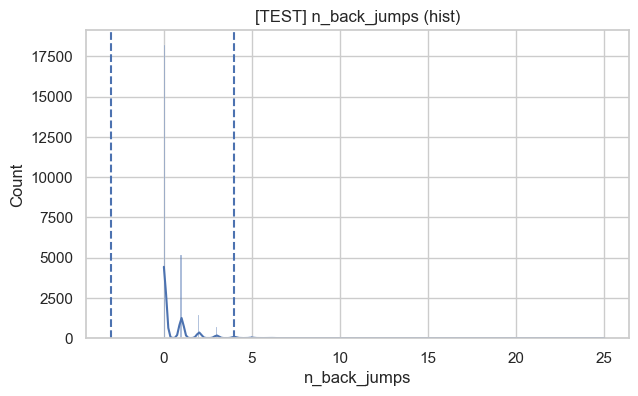

Total Process in Control: 22819 → within IQR limits: 17327 | Outliers removed: 5492
Total Process in Test: 25932 → within IQR limits: 22213 | Outliers removed: 3719


In [8]:
# 4) Visual scanning and counting
quick_outlier_scan(df_proc_control, title_prefix="[CONTROL] ")
quick_outlier_scan(df_proc_test,    title_prefix="[TEST] ")

# Quick outliers clean (IQR k=1.5 change to 3.0 less aggressive)
proc_control_no_out, proc_control_out = drop_outliers_iqr(df_proc_control, k=3.0, how='any')
proc_test_no_out,    proc_test_out    = drop_outliers_iqr(df_proc_test,    k=3.0, how='any')

print(f'Total Process in Control: {df_proc_control.shape[0]} → within IQR limits: {proc_control_no_out.shape[0]} | Outliers removed: {proc_control_out.shape[0]}')
print(f'Total Process in Test: {df_proc_test.shape[0]} → within IQR limits: {proc_test_no_out.shape[0]} | Outliers removed: {proc_test_out.shape[0]}')

# Save files
proc_control_no_out.to_csv(config['output_data']['file12'], index=False, sep=",", encoding="utf-8")
proc_test_no_out.to_csv(config['output_data']['file14'], index=False, sep=",", encoding="utf-8")
